In [42]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [44]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [46]:
# Paths
train_dir = r"C:\Users\ashwi\OneDrive\Desktop\Strabismus_New\train"
val_dir = r"C:\Users\ashwi\OneDrive\Desktop\Strabismus_New\val"
test_dir = r"C:\Users\ashwi\OneDrive\Desktop\Strabismus_New\test"

In [48]:
# Parameters
num_classes = 5
batch_size = 32
image_size = 224
num_epochs = 30

In [50]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
#Normalize: Scales pixel values from [0,1] to roughly [-1,1] using mean=0.5, std=0.5.

In [52]:
# Load datasets
train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

#pin_memory=True = faster data transfer to GPU (if using CUDA).
#num_workers=2 = number of threads to load data in parallel.

In [54]:
# Load DenseNet-121 with pretrained weights
model = models.densenet121(pretrained=True)

C:\Users\ashwi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ashwi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
# Freeze feature layers-so their weights aren’t updated during training (only fine-tuning the final layers).
for param in model.features.parameters():
    param.requires_grad = False

In [58]:
# Replace classifier
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

model = model.to(device)

In [60]:
# Label smoothing loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, target):
        log_probs = self.log_softmax(x)
        targets = torch.zeros_like(log_probs).scatter_(1, target.unsqueeze(1), 1)
        targets = targets * self.confidence + self.smoothing / self.cls
        return (-targets * log_probs).sum(dim=1).mean()

criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))

In [62]:
# Training function
def train_model():
    best_acc = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

        for images, labels in loop:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            loop.set_postfix(loss=running_loss / total, acc=100. * correct / total)

        scheduler.step()
        val_acc = evaluate_model(val_loader)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "densenet121_best.pth")

In [66]:
# Validation function
def evaluate_model(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    acc = 100. * correct / total
    print(f"Validation Accuracy: {acc:.2f}%")
    return acc

# Test function
def test_model():
    model.load_state_dict(torch.load("densenet121_best.pth"))
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    class_names = train_data.classes
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - DenseNet121")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

Validation Accuracy: 53.95%


Validation Accuracy: 60.53%


Validation Accuracy: 53.95%


Validation Accuracy: 56.58%


Validation Accuracy: 61.84%


Validation Accuracy: 53.95%


Validation Accuracy: 56.58%


Validation Accuracy: 55.26%


Validation Accuracy: 57.89%


Validation Accuracy: 51.32%


Validation Accuracy: 59.21%


Validation Accuracy: 55.26%


Validation Accuracy: 60.53%


Validation Accuracy: 53.95%


Validation Accuracy: 53.95%


Validation Accuracy: 56.58%


Validation Accuracy: 55.26%


Validation Accuracy: 59.21%


Validation Accuracy: 56.58%


Validation Accuracy: 56.58%


Validation Accuracy: 59.21%


Validation Accuracy: 55.26%


Validation Accuracy: 57.89%


Validation Accuracy: 59.21%


Validation Accuracy: 53.95%


Validation Accuracy: 57.89%


Validation Accuracy: 56.58%


Validation Accuracy: 56.58%


Validation Accuracy: 56.58%


Validation Accuracy: 55.26%


C:\Users\ashwi\AppData\Local\Temp\ipykernel_11652\3954485917.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("densenet121_best.pth"))


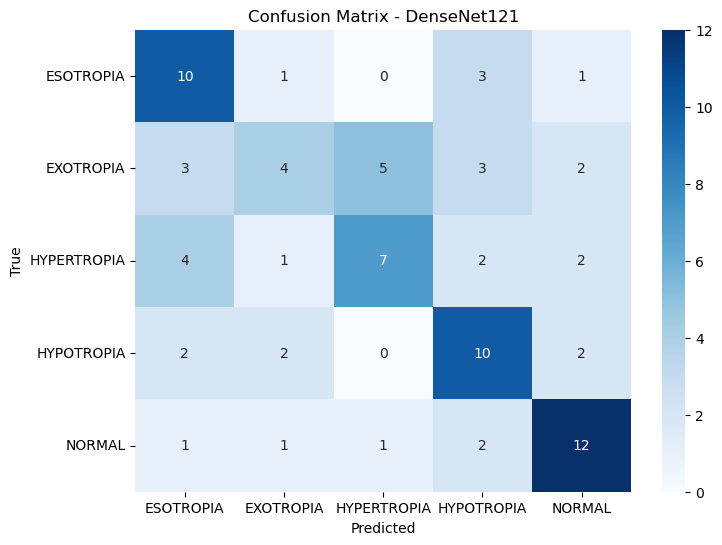


Classification Report:
              precision    recall  f1-score   support

   ESOTROPIA       0.50      0.67      0.57        15
   EXOTROPIA       0.44      0.24      0.31        17
 HYPERTROPIA       0.54      0.44      0.48        16
  HYPOTROPIA       0.50      0.62      0.56        16
      NORMAL       0.63      0.71      0.67        17

    accuracy                           0.53        81
   macro avg       0.52      0.53      0.52        81
weighted avg       0.52      0.53      0.52        81



In [68]:
# Run training and testing
train_model()
test_model()